# Data Preparation
Run all the code blocks under this section to prepare and preprocess data before feeding into the model.

**Mount google drive**

In [ ]:
""" Prepare Notebook for Google Colab """
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify directory of course materials in Google Drive
module_dir = (
   "/content/drive/My Drive/Group-5-Project/"
)

# Add course material directory in Google Drive to system path, for importing .py files later
# (Ref.: https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab)
import sys
sys.path.append(module_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



**Prepare Prerequisite Libraries**

In [ ]:
import torch 
import torch.nn as nn
import torchvision 
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

**Data Preprocessing**
<br>We have gathered 618 images, 206 for each class. Here we divide the dataset into training set, dev set and test set, and they have 498 images, 60 images and 60 images respectively. We also do data augmentation on the training set.

In [ ]:
height = 200 # use in CNN2
width = 200 # use in CNN2
# height = 299 # use in inception
# width = 299 # use in inception
# height = 100 # use in CNN(original)
# width = 100 # use in CNN(original)

# ResNet34 and VGG19 doesn't have input size specification

In [ ]:
# Transforming data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),   # Random horizontal flip of image, with prob = 0.5
    transforms.RandomRotation(degrees=90),    # Random rotation of image, with the range of degrees (-90, +90)                      
    transforms.Resize((height,width)),      # Resize images to size (height,width) default (200,200)
    transforms.ToTensor(),            # Convert PIL Image (HxWxC) to tensor (CxHxW)
                            # (CxHxW) format required by Conv2d layer in PyTorch

    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
                                   # Normalize RGB values from [0, 255]
                                   # to have specified mean/variance values.
                                   # This setting usually used with image normalization 
                                   # in PyTorch. 
])

test_transform = transforms.Compose([
    transforms.Resize((height,width)),  # Resize images to size (200, 200)
    transforms.ToTensor(),         # Convert PIL Image (HxWxC) to tensor (CxHxW)
                                   # (CxHxW) format required by Conv2d layer in PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
                                   # Normalize RGB values from [0, 255]
                                   # to have specified mean/variance values.
                                   # This setting usually used with image normalization 
                                   # in PyTorch. 
])

# Loading Data

# Splitting the data in training set and testing set. Further split testing set into dev set and test set.
flowers_dir = os.path.join(module_dir, "flowers/")
train_dir = os.path.join(flowers_dir, "train/")
test_dir = os.path.join(flowers_dir, "test/")

train_ds = torchvision.datasets.ImageFolder(root = train_dir, transform = transform)
dev_test_ds = torchvision.datasets.ImageFolder(root = test_dir, transform = test_transform)
test_size = int(0.5 * len(dev_test_ds))
dev_size = len(dev_test_ds) - test_size
dev_ds, test_ds = torch.utils.data.random_split(dev_test_ds, [dev_size, test_size])

from torch.utils.data import DataLoader
train_batch_size = 32
train_loader = DataLoader(train_ds, batch_size = train_batch_size, shuffle = True)
dev_batch_size = 32
dev_loader = DataLoader(dev_ds, batch_size=dev_batch_size, shuffle=True)
test_batch_size = 32
test_loader = DataLoader(test_ds, batch_size=test_batch_size, shuffle = True)

print("No of train ds Classes: ", len(train_ds.classes))
print(train_ds.classes)

print("Training Set Size: ", len(train_ds))
print("Dev Set Size: ", len(dev_ds))
print("Test Set Size: ", len(test_ds))


No of train ds Classes:  3
['cherry', 'peach', 'plum']
Training Set Size:  498
Dev Set Size:  60
Test Set Size:  60


# *CNN Model (prototype)*
This is the interim prototype. Our final model CNN2 is developed base on this model. **Please do not run the code block below as it is for your reference only.**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
print("-----")

######################### CNN Model #########################
class CNNClassifier(nn.Module): 
    def __init__(self):
        super(CNNClassifier, self).__init__()
        ##### Define CNN Model Layers #####
        # Expected input shape: (B, 3, 100, 100)
        # - B: Batch size
        # - 3: R, G, B channels
        # - 100,100: Fixed image size (100, 100)
        # (Changes of tensor shape after each layer are annotated below)

        # Convolutional layers
        self.layer1 = nn.Sequential(
					# After Conv2d: (B,3,100,100) -> (B,32,100,100)
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
					#(B,32,100,100) -> (B,32,100,100)
            nn.BatchNorm2d(32),
            nn.ReLU(True),
					# After MaxPool2d: (B,32,100,100) -> (B,32,50,50)
            nn.MaxPool2d(kernel_size=2), nn.Dropout(0.1)        
        )
        self.layer2 = nn.Sequential(
					# After Conv2d: (B,3,50,50) -> (B,32,50,50)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
					#(B,64,50,50) -> (B,64,50,50)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
					# After MaxPool2d: (B,64,50,50) -> (B,64,25,25)
            nn.MaxPool2d(kernel_size=2), nn.Dropout(0.1)        
        )
        self.layer3 = nn.Sequential(
					# After Conv2d: (B,64,25,25) -> (B,128,25,25)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
					#(B,128,25,25) -> (B,128,25,25)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
					# After MaxPool2d: (B,128,25,25) -> (B,128,12,12)
            nn.MaxPool2d(kernel_size=2), nn.Dropout(0.1)        
        )
        self.layer4 = nn.Sequential(
					# After Conv2d: (B,128,12,12) -> (B,256,12,12)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
					#(B,256,12,12) -> (B,256,12,12)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
					# After MaxPool2d: (B,256,12,12) -> (B,256,6,6)
            nn.MaxPool2d(kernel_size=2), nn.Dropout(0.1)        
        )

        self.fc = nn.Sequential(
            # After Flatten: (B,256,6,6) -> (B,256*6*6)
            nn.Flatten(),
            # After Linear: (B,256*6*6) -> (B,512)
            nn.Linear(6*6*256, 512),
            nn.ReLU(True),
            # After Linear: (B,512) -> (B,3)
            nn.Linear(512, 3)
        )
               
    def forward(self, x):
        # x: input tensor of an image batch of size (BxCxHxW)
        # pass image batch through Conv layers and FC layers.
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.fc(x)
        return x

# model = CNNClassifier()
# model = model.to(device)
# print("CNN Model Structure: ")
# print(model)

# ######################### Loss Function #########################
# criterion = nn.CrossEntropyLoss()
# ######################### Optimizer #########################
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Device:  cuda
-----


# **CNN2 Model (Use this to train)**
CNN2 Model added 1 sequential layer to prototype and fine tuned dropout rate. **Please run the code block below and use this model to train.**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
print("-----")

######################### CNN Model #########################
class CNNClassifier2(nn.Module): 
    def __init__(self):
        super(CNNClassifier2, self).__init__()
        ##### Define CNN Model Layers #####
        # Expected input shape: (B, 3, 200, 200)
        # - B: Batch size
        # - 3: R, G, B channels
        # - 200,200: Fixed image size (200, 200)
        # (Changes of tensor shape after each layer are annotated below)

        # Convolutional layers
        self.layer0 = nn.Sequential(
					# After Conv2d: (B,3,200,200) -> (B,32,200,200)
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
					#(B,32,200,200) -> (B,32,200,200)
            nn.BatchNorm2d(32),
            nn.ReLU(True),
					# After MaxPool2d: (B,32,200,200) -> (B,32,100,100)
            nn.MaxPool2d(kernel_size=2), nn.Dropout(0.1)        
        )
        self.layer1 = nn.Sequential(
					# After Conv2d: (B,32,100,100) -> (B,64,100,100)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
					#(B,64,100,100) -> (B,64,100,100)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
					# After MaxPool2d: (B,64,100,100) -> (B,64,50,50)
            nn.MaxPool2d(kernel_size=2), nn.Dropout(0.1)        
        )
        self.layer2 = nn.Sequential(
					# After Conv2d: (B,64,50,50) -> (B,128,50,50)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
					#(B,128,50,50) -> (B,128,50,50)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
					# After MaxPool2d: (B,128,50,50) -> (B,128,25,25)
            nn.MaxPool2d(kernel_size=2), nn.Dropout(0.1)        
        )
        self.layer3 = nn.Sequential(
					# After Conv2d: (B,128,25,25) -> (B,256,25,25)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
					#(B,256,25,25) -> (B,256,25,25)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
					# After MaxPool2d: (B,256,25,25) -> (B,256,12,12)
            nn.MaxPool2d(kernel_size=2), nn.Dropout(0.1)       
        )
        self.layer4 = nn.Sequential(
					# After Conv2d: (B,256,12,12) -> (B,512,12,12)
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
					#(B,512,12,12) -> (B,512,12,12)
            nn.BatchNorm2d(512),
            nn.ReLU(True),
					# After MaxPool2d: (B,512,12,12) -> (B,512,6,6)
            nn.MaxPool2d(kernel_size=2), nn.Dropout(0.1)        
        )

        self.fc = nn.Sequential(
            # After Flatten: (B,512,6,6) -> (B,512*6*6)
            nn.Flatten(),
            # After Linear: (B,512*6*6) -> (B,512)
            nn.Linear(6*6*512, 512),
            nn.ReLU(True),
            # After Linear: (B,512) -> (B,3)
            nn.Linear(512, 3)
        )
               
    def forward(self, x):
        # x: input tensor of an image batch of size (BxCxHxW)
        # pass image batch through Conv layers and FC layers.
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.fc(x)
        return x

model = CNNClassifier2()
model = model.to(device)
print("CNN2 Model Structure: ")
print(model)

######################### Loss Function #########################
criterion = nn.CrossEntropyLoss()
######################### Optimizer #########################
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Device:  cuda
-----
CNN2 Model Structure: 
CNNClassifier2(
  (layer0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
  )
  (layer1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.1, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stri

# *CNN3 Model (added more Conv2d layers)*
This is used for experiment. We are inspired by VGG19 and added more Conv2d layers to see if the result is better.
**Please do not run the code block below as it is for experiment only.**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
print("-----")

######################### CNN Model #########################
class CNNClassifier3(nn.Module): 
    def __init__(self):
        super(CNNClassifier3, self).__init__()
        ##### Define CNN Model Layers #####
        # Expected input shape: (B, 3, 200, 200)
        # - B: Batch size
        # - 3: R, G, B channels
        # - 200,200: Fixed image size (200, 200)
        # (Changes of tensor shape after each layer are annotated below)

        # Convolutional layers

        self.layer0 = nn.Sequential(
					# After Conv2d: (B,3,200,200) -> (B,64,200,200)
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
					#(B,64,200,200) -> (B,64,200,200)
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
					# After MaxPool2d: (B,64,200,200) -> (B,64,100,100)
            nn.MaxPool2d(kernel_size=2)      
        )
        self.layer1 = nn.Sequential(
					# After Conv2d: (B,64,100,100) -> (B,128,100,100)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
					#(B,128,100,100) -> (B,128,100,100)
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
					# After MaxPool2d: (B,128,100,100) -> (B,128,50,50)
            nn.MaxPool2d(kernel_size=2), nn.Dropout(0.25)        
        )
        self.layer2 = nn.Sequential(
					# After Conv2d: (B,128,50,50) -> (B,256,50,50)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
					#(B,256,50,50) -> (B,256,50,50)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
					# After MaxPool2d: (B,256,50,50) -> (B,256,25,25)
            nn.MaxPool2d(kernel_size=2), nn.Dropout(0.25)        
        )
        self.layer3 = nn.Sequential(
					# After Conv2d: (B,256,25,25) -> (B,512,25,25)
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
					#(B,512,25,25) -> (B,512,25,25)
            nn.BatchNorm2d(512),
            nn.ReLU(True),
					# After MaxPool2d: (B,512,25,25) -> (B,512,12,12)
            nn.MaxPool2d(kernel_size=2), nn.Dropout(0.25)        
        )
        self.layer4 = nn.Sequential(
					# After Conv2d: (B,512,12,12) -> (B,1024,12,12)
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
					#(B,1024,12,12) -> (B,1024,12,12)
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
					# After MaxPool2d: (B,1024,12,12) -> (B,1024,6,6)
            nn.MaxPool2d(kernel_size=2)        
        )

        self.fc = nn.Sequential(
            # After Flatten: (B,1024,6,6) -> (B,1024*6*6)
            nn.Flatten(),
            # After Linear: (B,1024*6*6) -> (B,512)
            nn.Linear(6*6*1024, 512),
            nn.ReLU(True),
            # After Linear: (B,512) -> (B,3)
            nn.Linear(512, 3)
        )
               
    def forward(self, x):
        # x: input tensor of an image batch of size (BxCxHxW)
        # pass image batch through Conv layers and FC layers.
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.fc(x)
        return x

model = CNNClassifier3()
model = model.to(device)
print("CNN Model Structure: ")
print(model)

######################### Loss Function #########################
criterion = nn.CrossEntropyLoss()
######################### Optimizer #########################
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Device:  cuda
-----
CNN Model Structure: 
CNNClassifier3(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(256, 256, kernel_size=(3

# Training
**The training of our CNN2 model takes around 20 minutes.**

In [ ]:
N_EPOCH = 100

In [ ]:
from time import time


Loss = []
Acc = []
Dev_Loss = []
Dev_Acc = []

start_time = time()
for epoch in range(N_EPOCH) :
    train_acc = 0
    dev_acc = 0
    train_preds = 0
    dev_preds = 0
    total_preds = 0
    dev_total_preds = 0
    print('===== Epoch {} ====='.format(epoch))

    for i, (images, labels) in enumerate(train_loader):
      model.train() #use in CNN, ResNet
      images, labels = images.to(device), labels.to(device)
      # optimizer.zero_grad()
      outputs = model(images) #use in CNN, ResNet
      train_loss = criterion(outputs, labels) #use in CNN, ResNet
      # train_loss = criterion(outputs.logits, labels)
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()  # use in CNN
      # optimizer.zero_grad() # use in ResNet
      # preds = outputs.data.max(dim=1,keepdim=True)[1]
      # train_acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
      _, predicted = torch.max(outputs.data, 1) ##use in CNN, ResNet
      # _, predicted = torch.max(outputs.logits, 1)
      train_preds += (predicted == labels).sum().item()
      total_preds += torch.tensor(predicted.shape).prod().item()



    #train_acc = train_acc/len(train_loader.dataset) * 100
    train_acc = train_preds/total_preds

    for i, (images, labels) in enumerate(dev_loader):
      model.eval()
      images, labels = images.to(device), labels.to(device)
      with torch.no_grad():
        outputs = model(images) #use in CNN, resnet
      # print("output:", outputs)
      dev_loss = criterion(outputs, labels) #use in CNN, resnet
      # preds = outputs.data.max(dim=1,keepdim=True)[1]
      # dev_acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
      _, predicted = torch.max(outputs.data, 1) #use in CNN, resnet
      # _, predicted = torch.max(outputs, 1)
      dev_preds += (predicted == labels).sum().item()
      dev_total_preds += torch.tensor(predicted.shape).prod().item()

    #dev_acc = dev_acc/len(dev_loader.dataset) * 100
    dev_acc = dev_preds/dev_total_preds


    end_time = time()
    print("Time: {}".format(end_time-start_time))
    print("----- Training -----")
    print("Loss: {}".format(train_loss.item()))
    print("Acc: {}".format(train_acc))
    print("----- Dev -----")
    print("Loss: {}".format(dev_loss.item()))
    print("Acc: {}".format(dev_acc))
    print('====================')
    Loss.append(train_loss)
    Acc.append(train_acc)
    Dev_Loss.append(dev_loss)
    Dev_Acc.append(dev_acc)


===== Epoch 0 =====
Time: 11.380395650863647
----- Training -----
Loss: 2.5645346641540527
Acc: 0.3614457831325301
----- Dev -----
Loss: 2.6325364112854004
Acc: 0.4
===== Epoch 1 =====
Time: 22.710451364517212
----- Training -----
Loss: 1.2223466634750366
Acc: 0.3634538152610442
----- Dev -----
Loss: 1.3178831338882446
Acc: 0.35
===== Epoch 2 =====
Time: 34.07148289680481
----- Training -----
Loss: 0.9554082155227661
Acc: 0.4979919678714859
----- Dev -----
Loss: 1.710102915763855
Acc: 0.4666666666666667
===== Epoch 3 =====
Time: 45.38947558403015
----- Training -----
Loss: 0.8364245891571045
Acc: 0.5401606425702812
----- Dev -----
Loss: 1.2202966213226318
Acc: 0.45
===== Epoch 4 =====
Time: 56.70533084869385
----- Training -----
Loss: 0.6966090202331543
Acc: 0.570281124497992
----- Dev -----
Loss: 0.893110454082489
Acc: 0.5333333333333333
===== Epoch 5 =====
Time: 68.05275654792786
----- Training -----
Loss: 0.8624354600906372
Acc: 0.5602409638554217
----- Dev -----
Loss: 1.06586861610

# Evaluation
Here we use the test set to evaluate our model. The test set contains 60 images and the accuracy of our model is around 60% to 70%.
<br>The loss graph and accuracy graph are also shown below.

In [ ]:
# """ Evaluate Model """
# ######################## Model Evaluation #########################
# # Evaluate model performance with test dataset (Test score)
model.eval()  
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:

    # y_pred = []
    Images = images.to(device)
    Labels = labels.to(device)
    outputs = model(Images)
    # prediction_array = outputs.data
        
    #_, predicted = torch.max(prediction_array, 1)
    _, predicted = torch.max(outputs.data, 1)
    #y_pred += predicted
    total += Labels.size(0)
    correct += (predicted == Labels).sum().item()
        
    acc = 100 * correct / total

    print('Accuracy of the network on %d images: %.2f %%' % (total,acc))

Accuracy of the network on 32 images: 75.00 %
Accuracy of the network on 60 images: 70.00 %


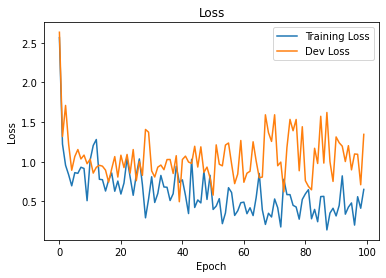

In [ ]:
plt.plot(range(N_EPOCH),Loss)
plt.plot(range(N_EPOCH),Dev_Loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss")
plt.legend(["Training Loss", "Dev Loss"])
plt.show()

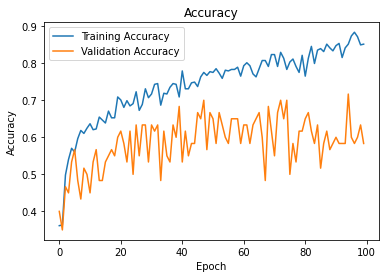

In [ ]:
plt.plot(range(N_EPOCH),Acc)
plt.plot(range(N_EPOCH),Dev_Acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

# *Transfer Learning*
We used ResNet34, VGG19 and Inception V3 for transfer learning. We use transfer learning to do analysis. We compare their results with our model and try to improve our model. If you are interested in these models, you can run the code blocks below. All of them have individual training and evaluation process. However, it is **not recommended to run** as it takes time. You can simply view our test output below.

## ResNet34



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
print("-----")

resnet34 = torchvision.models.resnet34(pretrained=True)
ftr = resnet34.fc.in_features
resnet34.fc = nn.Linear(ftr, 3)

resnet34 = resnet34.cuda()

model_RN = resnet34
model_RN = model_RN.to(device)
print("ResNet34 Model Structure: ")
print(model_RN)

######################### Loss Function #########################
criterion = nn.CrossEntropyLoss()
######################### Optimizer #########################
optimizer = torch.optim.Adam(model_RN.parameters(), lr=0.001)

Device:  cuda
-----


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



ResNet34 Model Structure: 
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

In [ ]:
from time import time


Loss_RN = []
Acc_RN = []
Dev_Loss_RN = []
Dev_Acc_RN = []

start_time = time()
for epoch in range(N_EPOCH) :
    train_acc = 0
    dev_acc = 0
    train_preds = 0
    dev_preds = 0
    total_preds = 0
    dev_total_preds = 0
    print('===== Epoch {} ====='.format(epoch))

    for i, (images, labels) in enumerate(train_loader):
      model_RN.train() #use in CNN, ResNet
      images, labels = images.to(device), labels.to(device)
      # optimizer.zero_grad()
      outputs = model_RN(images) #use in CNN, ResNet
      train_loss = criterion(outputs, labels) #use in CNN, ResNet
      # train_loss = criterion(outputs.logits, labels)
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()  # use in CNN
      # optimizer.zero_grad() # use in ResNet
      # preds = outputs.data.max(dim=1,keepdim=True)[1]
      # train_acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
      _, predicted = torch.max(outputs.data, 1) ##use in CNN, ResNet
      # _, predicted = torch.max(outputs.logits, 1)
      train_preds += (predicted == labels).sum().item()
      total_preds += torch.tensor(predicted.shape).prod().item()



    #train_acc = train_acc/len(train_loader.dataset) * 100
    train_acc = train_preds/total_preds

    for i, (images, labels) in enumerate(dev_loader):
      model_RN.eval()
      images, labels = images.to(device), labels.to(device)
      with torch.no_grad():
        outputs = model_RN(images) #use in CNN, resnet
      # print("output:", outputs)
      dev_loss = criterion(outputs, labels) #use in CNN, resnet
      # preds = outputs.data.max(dim=1,keepdim=True)[1]
      # dev_acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
      _, predicted = torch.max(outputs.data, 1) #use in CNN, resnet
      # _, predicted = torch.max(outputs, 1)
      dev_preds += (predicted == labels).sum().item()
      dev_total_preds += torch.tensor(predicted.shape).prod().item()

    #dev_acc = dev_acc/len(dev_loader.dataset) * 100
    dev_acc = dev_preds/dev_total_preds


    end_time = time()
    print("Time: {}".format(end_time-start_time))
    print("----- Training -----")
    print("Loss: {}".format(train_loss.item()))
    print("Acc: {}".format(train_acc))
    print("----- Dev -----")
    print("Loss: {}".format(dev_loss.item()))
    print("Acc: {}".format(dev_acc))
    print('====================')
    Loss_RN.append(train_loss)
    Acc_RN.append(train_acc)
    Dev_Loss_RN.append(dev_loss)
    Dev_Acc_RN.append(dev_acc)

===== Epoch 0 =====
Time: 11.645279169082642
----- Training -----
Loss: 1.186689853668213
Acc: 0.5602409638554217
----- Dev -----
Loss: 96.9099349975586
Acc: 0.36666666666666664
===== Epoch 1 =====
Time: 23.17747163772583
----- Training -----
Loss: 0.5872711539268494
Acc: 0.6044176706827309
----- Dev -----
Loss: 2.6251606941223145
Acc: 0.5333333333333333
===== Epoch 2 =====
Time: 34.889315366744995
----- Training -----
Loss: 1.0231800079345703
Acc: 0.7128514056224899
----- Dev -----
Loss: 4.223819255828857
Acc: 0.45
===== Epoch 3 =====
Time: 46.47712254524231
----- Training -----
Loss: 0.6692728400230408
Acc: 0.7269076305220884
----- Dev -----
Loss: 0.9704924821853638
Acc: 0.5833333333333334
===== Epoch 4 =====
Time: 58.153080701828
----- Training -----
Loss: 0.967121422290802
Acc: 0.7570281124497992
----- Dev -----
Loss: 1.47361159324646
Acc: 0.5333333333333333
===== Epoch 5 =====
Time: 69.79380249977112
----- Training -----
Loss: 0.3651919960975647
Acc: 0.7389558232931727
----- Dev -

In [ ]:
# """ Evaluate Model """
# ######################## Model Evaluation #########################
# # Evaluate model performance with test dataset (Test score)
#Accuracies=[]
model_RN.eval()  
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:

    # y_pred = []
    Images = images.to(device)
    Labels = labels.to(device)
    outputs = model_RN(Images)
    # prediction_array = outputs.data
        
    #_, predicted = torch.max(prediction_array, 1)
    _, predicted = torch.max(outputs.data, 1)
    #y_pred += predicted
    total += Labels.size(0)
    correct += (predicted == Labels).sum().item()
        
    acc = 100 * correct / total

    print('Accuracy of the network on %d images: %.2f %%' % (total,acc))

Accuracy of the network on 32 images: 78.12 %
Accuracy of the network on 60 images: 76.67 %


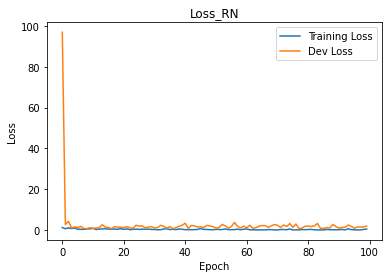

In [ ]:
plt.plot(range(N_EPOCH),Loss_RN)
plt.plot(range(N_EPOCH),Dev_Loss_RN)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss_RN")
plt.legend(["Training Loss", "Dev Loss"])
plt.show()

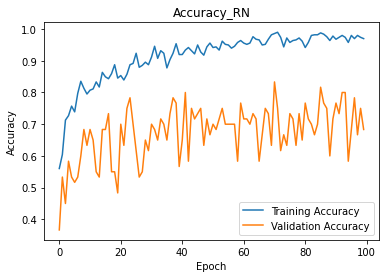

In [ ]:
plt.plot(range(N_EPOCH),Acc_RN)
plt.plot(range(N_EPOCH),Dev_Acc_RN)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy_RN")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

## VGG19

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
print("-----")

vgg = torchvision.models.vgg19(pretrained=True)

vgg.classifier[6].out_features = 3
for param in vgg.features.parameters(): 
    param.requires_grad = False

vgg = vgg.cuda()

model_VGG = vgg
model_VGG = model_VGG.to(device)
print("VGG19 Model Structure: ")
print(model_VGG)

######################### Loss Function #########################
criterion = nn.CrossEntropyLoss()
######################### Optimizer #########################
optimizer = torch.optim.Adam(model_VGG.parameters(), lr=0.001)

Device:  cuda
-----
VGG19 Model Structure: 
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 

In [ ]:
from time import time


Loss_VGG = []
Acc_VGG = []
Dev_Loss_VGG = []
Dev_Acc_VGG = []

N_EPOCH = 100

start_time = time()
for epoch in range(N_EPOCH) :
    train_acc = 0
    dev_acc = 0
    train_preds = 0
    dev_preds = 0
    total_preds = 0
    dev_total_preds = 0
    print('===== Epoch {} ====='.format(epoch))

    for i, (images, labels) in enumerate(train_loader):
      model_VGG.train() #use in CNN, ResNet
      images, labels = images.to(device), labels.to(device)
      # optimizer.zero_grad()
      outputs = model_VGG(images) #use in CNN, ResNet
      train_loss = criterion(outputs, labels) #use in CNN, ResNet
      # train_loss = criterion(outputs.logits, labels)
      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()  # use in CNN
      # optimizer.zero_grad() # use in ResNet
      # preds = outputs.data.max(dim=1,keepdim=True)[1]
      # train_acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
      _, predicted = torch.max(outputs.data, 1) ##use in CNN, ResNet
      # _, predicted = torch.max(outputs.logits, 1)
      train_preds += (predicted == labels).sum().item()
      total_preds += torch.tensor(predicted.shape).prod().item()



    #train_acc = train_acc/len(train_loader.dataset) * 100
    train_acc = train_preds/total_preds

    for i, (images, labels) in enumerate(dev_loader):
      model_VGG.eval()
      images, labels = images.to(device), labels.to(device)
      with torch.no_grad():
        outputs = model_VGG(images) #use in CNN, resnet
      # print("output:", outputs)
      dev_loss = criterion(outputs, labels) #use in CNN, resnet
      # preds = outputs.data.max(dim=1,keepdim=True)[1]
      # dev_acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
      _, predicted = torch.max(outputs.data, 1) #use in CNN, resnet
      # _, predicted = torch.max(outputs, 1)
      dev_preds += (predicted == labels).sum().item()
      dev_total_preds += torch.tensor(predicted.shape).prod().item()

    #dev_acc = dev_acc/len(dev_loader.dataset) * 100
    dev_acc = dev_preds/dev_total_preds


    end_time = time()
    print("Time: {}".format(end_time-start_time))
    print("----- Training -----")
    print("Loss: {}".format(train_loss.item()))
    print("Acc: {}".format(train_acc))
    print("----- Dev -----")
    print("Loss: {}".format(dev_loss.item()))
    print("Acc: {}".format(dev_acc))
    print('====================')
    Loss_VGG.append(train_loss)
    Acc_VGG.append(train_acc)
    Dev_Loss_VGG.append(dev_loss)
    Dev_Acc_VGG.append(dev_acc)

===== Epoch 0 =====
Time: 12.56392765045166
----- Training -----
Loss: 1.297160267829895
Acc: 0.42771084337349397
----- Dev -----
Loss: 1.4180806875228882
Acc: 0.5166666666666667
===== Epoch 1 =====
Time: 25.121594190597534
----- Training -----
Loss: 1.1163134574890137
Acc: 0.5461847389558233
----- Dev -----
Loss: 1.1919090747833252
Acc: 0.45
===== Epoch 2 =====
Time: 37.669021129608154
----- Training -----
Loss: 0.7904146313667297
Acc: 0.5421686746987951
----- Dev -----
Loss: 1.0883734226226807
Acc: 0.5166666666666667
===== Epoch 3 =====
Time: 50.284961462020874
----- Training -----
Loss: 0.9880725145339966
Acc: 0.6345381526104418
----- Dev -----
Loss: 0.9920360445976257
Acc: 0.6666666666666666
===== Epoch 4 =====
Time: 62.870070695877075
----- Training -----
Loss: 0.8307912349700928
Acc: 0.6385542168674698
----- Dev -----
Loss: 0.8503065705299377
Acc: 0.6
===== Epoch 5 =====
Time: 75.4964747428894
----- Training -----
Loss: 0.7812813520431519
Acc: 0.6506024096385542
----- Dev -----
L

In [ ]:
# """ Evaluate Model """
# ######################## Model Evaluation #########################
# # Evaluate model performance with test dataset (Test score)
#Accuracies=[]
model_VGG.eval()  
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:

    # y_pred = []
    Images = images.to(device)
    Labels = labels.to(device)
    outputs = model_VGG(Images)
    # prediction_array = outputs.data
        
    #_, predicted = torch.max(prediction_array, 1)
    _, predicted = torch.max(outputs.data, 1)
    #y_pred += predicted
    total += Labels.size(0)
    correct += (predicted == Labels).sum().item()
        
    acc = 100 * correct / total

    print('Accuracy of the network on %d images: %.2f %%' % (total,acc))

Accuracy of the network on 32 images: 75.00 %
Accuracy of the network on 60 images: 76.67 %


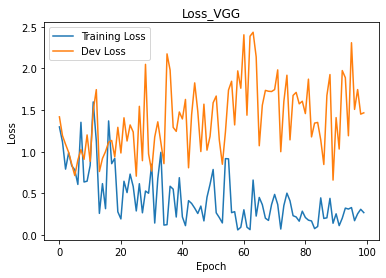

In [ ]:
plt.plot(range(N_EPOCH),Loss_VGG)
plt.plot(range(N_EPOCH),Dev_Loss_VGG)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss_VGG")
plt.legend(["Training Loss", "Dev Loss"])
plt.show()

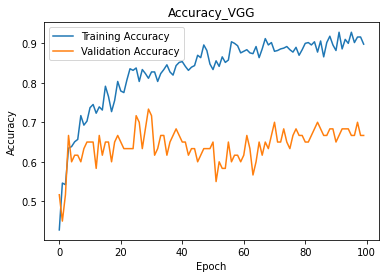

In [ ]:
plt.plot(range(N_EPOCH),Acc_VGG)
plt.plot(range(N_EPOCH),Dev_Acc_VGG)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy_VGG")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

## Inception V3

In [ ]:
height = 299 # use in inception
width = 299 # use in inception

transform_inception = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),   # Random horizontal flip of image, with prob = 0.5
    #transforms.RandomVerticalFlip(p=0.5),    # Random vertical flip of image, with prob = 0.5
    transforms.RandomRotation(degrees=90),    # Random rotation of image, with the range of degrees (-90, +90)                      
    transforms.Resize((height,width)),      # Resize images to size (height,width) default (100,100)
    transforms.ToTensor(),            # Convert PIL Image (HxWxC) to tensor (CxHxW)
                            # (CxHxW) format required by Conv2d layer in PyTorch

    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
                                   # Normalize RGB values from [0, 255]
                                   # to have specified mean/variance values.
                                   # This setting usually used with image normalization 
                                   # in PyTorch. 
])

test_transform_inception = transforms.Compose([
    transforms.Resize((height,width)),  # Resize images to size (100, 100)
    transforms.ToTensor(),         # Convert PIL Image (HxWxC) to tensor (CxHxW)
                                   # (CxHxW) format required by Conv2d layer in PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
                                   # Normalize RGB values from [0, 255]
                                   # to have specified mean/variance values.
                                   # This setting usually used with image normalization 
                                   # in PyTorch. 
])

train_ds_InceptionV3 = torchvision.datasets.ImageFolder(root = train_dir, transform = transform_inception)
dev_test_ds_InceptionV3 = torchvision.datasets.ImageFolder(root = test_dir, transform = test_transform_inception)
test_size_InceptionV3 = int(0.5 * len(dev_test_ds_InceptionV3))
dev_size_InceptionV3 = len(dev_test_ds_InceptionV3) - test_size_InceptionV3
dev_ds_InceptionV3, test_ds_InceptionV3 = torch.utils.data.random_split(dev_test_ds_InceptionV3, [dev_size_InceptionV3, test_size_InceptionV3])


train_batch_size_InceptionV3 = 32
train_loader_InceptionV3 = DataLoader(train_ds_InceptionV3, batch_size = train_batch_size_InceptionV3, shuffle = True)
dev_batch_size_InceptionV3 = 32
dev_loader_InceptionV3 = DataLoader(dev_ds_InceptionV3, batch_size=dev_batch_size_InceptionV3, shuffle=True)
test_batch_size_InceptionV3 = 32
test_loader_InceptionV3 = DataLoader(test_ds_InceptionV3, batch_size=test_batch_size_InceptionV3, shuffle = True)

print("Training Set Size: ", len(train_ds))
print("Dev Set Size: ", len(dev_ds))
print("Test Set Size: ", len(test_ds))


Training Set Size:  498
Dev Set Size:  60
Test Set Size:  60


In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

def train_model(model, dataloaders, criterion, optimizer, num_epochs=100, is_inception=False):

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    start_time = time.time()
    for epoch in range(num_epochs):
        print('===== Epoch {} ====='.format(epoch))
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            end_time = time.time()
            
            if phase == 'train':
              print("Time: {}".format(end_time-start_time))
              print("----- Training -----")
              print("Loss: {}".format(epoch_loss))
              print("Acc: {}".format(epoch_acc))
              Loss_InceptionV3.append(epoch_loss)
              Acc_InceptionV3.append(epoch_acc)
            else:
              print("----- Dev -----")
              print("Loss: {}".format(epoch_loss))
              print("Acc: {}".format(epoch_acc))
              Dev_Loss_InceptionV3.append(epoch_loss)
              Dev_Acc_InceptionV3.append(epoch_acc)


            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print('====================')

    time_elapsed = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    input_size = 0

    """ Inception v3
    Be careful, expects (299,299) sized images and has auxiliary output
        """
    model = models.inception_v3(pretrained=use_pretrained)
    set_parameter_requires_grad(model, feature_extract)
    # Handle the auxilary net
    num_ftrs = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
    # Handle the primary net
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs,num_classes)
    input_size = 299


    return model, input_size

model_name = "inception"
num_classes = 3
batch_size = 8
num_epochs = 100
feature_extract = True


Loss_InceptionV3 = []
Acc_InceptionV3 = []
Dev_Loss_InceptionV3 = []
Dev_Acc_InceptionV3 = []


# Initialize the model for this run
model_InceptionV3, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_InceptionV3)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: ", device)
print("-----")

# Send the model to GPU
model_InceptionV3 = model_InceptionV3.to(device)

dataloaders_dict = {}
dataloaders_dict['train'] = train_loader_InceptionV3
dataloaders_dict['val'] = dev_loader_InceptionV3

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_InceptionV3.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_InceptionV3.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_InceptionV3.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_InceptionV3, hist = train_model(model_InceptionV3, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

PyTorch Version:  1.8.1+cu101
Torchvision Version:  0.9.1+cu101
Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): B

In [ ]:
# """ Evaluate Model """
# ######################## Model Evaluation #########################
# # Evaluate model performance with test dataset (Test score)
#Accuracies=[]
model_InceptionV3.eval()  
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:

    # y_pred = []
    Images = images.to(device)
    Labels = labels.to(device)
    outputs = model_InceptionV3(Images)
    # prediction_array = outputs.data
        
    #_, predicted = torch.max(prediction_array, 1)
    _, predicted = torch.max(outputs.data, 1)
    #y_pred += predicted
    total += Labels.size(0)
    correct += (predicted == Labels).sum().item()
        
    acc = 100 * correct / total

    print('Accuracy of the network on %d images: %.2f %%' % (total,acc))

Accuracy of the network on 32 images: 56.25 %
Accuracy of the network on 60 images: 58.33 %


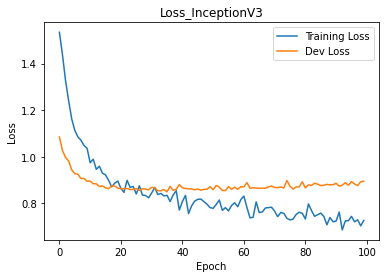

In [ ]:
plt.plot(range(N_EPOCH),Loss_InceptionV3)
plt.plot(range(N_EPOCH),Dev_Loss_InceptionV3)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss_InceptionV3")
plt.legend(["Training Loss", "Dev Loss"])
plt.show()

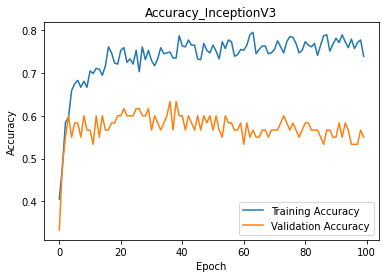

In [ ]:
plt.plot(range(N_EPOCH),Acc_InceptionV3)
plt.plot(range(N_EPOCH),Dev_Acc_InceptionV3)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy_InceptionV3")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()



# Reuse Model and Make Predictions
Please put the images to be predicted into the directory "/images"
<br>Run the code block below to see the predictions made by our model to your images.

Prediction results: 


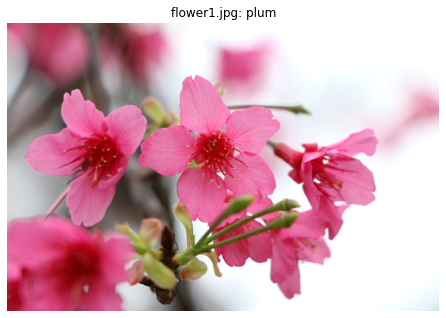

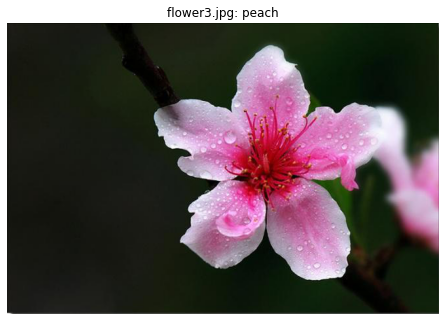

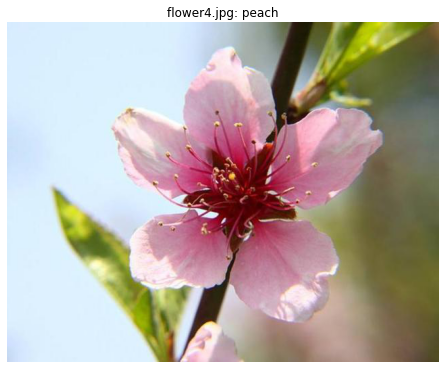

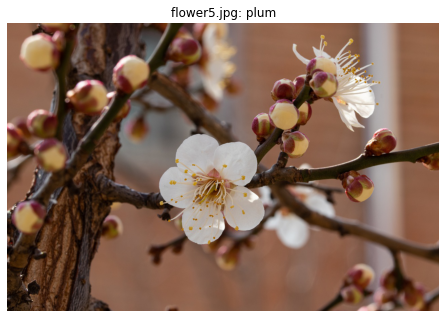

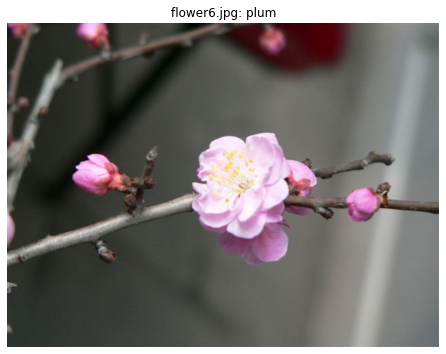

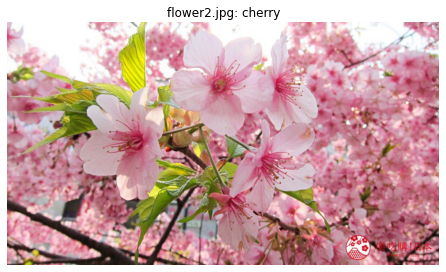

In [ ]:
""" Reuse Trained Model and Make Prediction """

import skimage
from skimage import io
from PIL import Image
# Specify data directory
data_dir = "images/"

# Get image paths in data_dir
import os
#data_paths = os.path.join(module_dir,data_dir)
data_paths = os.path.join(module_dir,data_dir)
data_path=data_paths
data_paths = [ os.path.join(data_paths, p) for p in os.listdir(data_paths) ]
#print(data_paths)
##### Load Images #####
# Load all images into one big tensor
image_batch = []

for path in data_paths :
  
    image = Image.open(path)
    image_tensor = transform(image)

  
    image_batch.append(image_tensor)

# Pack list of image tensors into one big tensor.
image_batch = torch.stack(image_batch)

with torch.no_grad() : 
  # Make predictions using trained model
    pred_labels = torch.max(model(image_batch.to(device)).data,1)[1]

# Print out prediction results
pred_class_names = [ train_ds.classes[pl] for pl in pred_labels ]

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print("Prediction results: ")

for i in range(len(pred_class_names)):
  image = mpimg.imread(os.path.join(data_path,os.listdir(data_path)[i]))
  plt.figure()
  plt.axis('off')
  plt.title(os.listdir(data_path)[i]+': '+pred_class_names[i])
  plt.subplots_adjust(left=0, bottom=0, right=1, top=20, wspace=0, hspace=0)
  plt.imshow(image)
  